In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as sabr
from pysabr.black import lognormal_call

In [13]:
from openbb import obb
import os

In [14]:
df_daily = obb.equity.price.historical(symbol = "spy", provider="yfinance")
df_daily.to_df().head(1)

,open,high,low,close,volume,dividend
date,,,,,,
2023-12-06,458.809998,458.839996,454.309998,454.76001,69124700,0.0


In [25]:
from openbb import obb

# Define variables
symbol = "SPY"

# Fetch options chain
df_options = obb.derivatives.options.chains(symbol=symbol, provider="yfinance")

# Convert to DataFrame and print the first row
print(df_options.to_df().head(1))


  underlying_symbol  underlying_price     contract_symbol  expiration  dte  \
0               SPY            606.66  SPY241206C00300000  2024-12-06    0   

   strike option_type  open_interest  volume  last_trade_price  \
0   300.0        call              0     228            304.05   

            last_trade_time  bid  ask  change  change_percent  \
0 2024-12-02 15:08:39-05:00  0.0  0.0     0.0             0.0   

   implied_volatility  in_the_money currency  
0             0.00001          True      USD  


In [26]:
import pandas as pd
from datetime import timedelta

# Convert OBBject to a DataFrame
df_options = df_options.to_df()  # Ensure this conversion is done before accessing columns

# Adjust expiration to tomorrow for testing
expiration = pd.Timestamp.today() + timedelta(days=4)
expiration = expiration.normalize()  # Optional: Ensure it's at midnight

# Ensure expiration column is in datetime format
df_options["expiration"] = pd.to_datetime(df_options["expiration"])
expiration = pd.to_datetime(expiration)

# Filter calls
calls = df_options[df_options["option_type"] == "call"]
print("Filtered calls DataFrame:")
print(calls.head())

jan_today_c = calls[calls["expiration"] == expiration]
print("Filtered calls for today's expiration:")
print(jan_today_c.head())

jan_today_c = jan_today_c.set_index("strike")
jan_today_c["mid"] = (jan_today_c["bid"] + jan_today_c["ask"]) / 2

# Filter puts
puts = df_options[df_options["option_type"] == "put"]
print("Filtered puts DataFrame:")
print(puts.head())

jan_today_p = puts[puts["expiration"] == expiration]
print("Filtered puts for expiration:")
print(jan_today_p.head())

jan_today_p = jan_today_p.set_index("strike")
jan_today_p["mid"] = (jan_today_p["bid"] + jan_today_p["ask"]) / 2

# Extract strikes and volatilities
strikes = jan_today_c.index
vols = jan_today_c["implied_volatility"] * 100

# Final output
print("Strikes:", strikes)
print("Volatilities:", vols)


Filtered calls DataFrame:
   underlying_symbol  underlying_price     contract_symbol expiration  dte  \
0                SPY            606.66  SPY241206C00300000 2024-12-06    0   
4                SPY            606.66  SPY241206C00350000 2024-12-06    0   
8                SPY            606.66  SPY241206C00365000 2024-12-06    0   
12               SPY            606.66  SPY241206C00380000 2024-12-06    0   
17               SPY            606.66  SPY241206C00400000 2024-12-06    0   

    strike option_type  open_interest  volume  last_trade_price  \
0    300.0        call              0     228            304.05   
4    350.0        call              0      70            244.67   
8    365.0        call              0       0            235.80   
12   380.0        call              0       0            217.50   
17   400.0        call              0      40            207.45   

             last_trade_time  bid  ask  change  change_percent  \
0  2024-12-02 15:08:39-05:00  0.0  0

In [27]:
import pandas as pd

# Compute the forward stock price using put-call parity
f = (
    (jan_today_c["mid"] - jan_today_p["mid"])  # Calculate call minus put midpoint
    .dropna()  # Remove NaN values
    .abs()  # Take absolute values
    .sort_values()  # Sort by absolute value
    .index[0]  # Get the strike price that minimizes the absolute difference
)

# Compute time to expiration in years
t = (pd.Timestamp(expiration) - pd.Timestamp.now()).days / 365

# Assign beta (example: 0.5)
beta = 0.5

# Print the results for validation
print("Forward stock price (f):", f)
print("Time to expiration (t):", t)
print("Beta:", beta)


Forward stock price (f): 575.0
Time to expiration (t): 0.00821917808219178
Beta: 0.5


In [29]:
from pysabr import Hagan2002LognormalSABR
import numpy as np

# Filter valid data (Ensure all volatilities and strikes are valid)
valid_data = (vols > 0) & (strikes > 0)  # Both volatilities and strikes must be positive
strikes = strikes[valid_data]
vols = np.maximum(vols[valid_data], 1e-8)  # Avoid very small volatilities

# Ensure forward price and time to expiration are positive
if f <= 0:
    raise ValueError(f"Forward price (f) must be positive. Got f={f}.")
if t <= 0:
    raise ValueError(f"Time to expiration (t) must be positive. Got t={t}.")

# Print filtered strikes and volatilities for debugging
if len(strikes) == 0 or len(vols) == 0:
    raise ValueError("No valid strikes or volatilities after filtering.")
print("Filtered Strikes:", strikes)
print("Filtered Volatilities:", vols)

# SABR model fitting
try:
    sabr_lognormal = Hagan2002LognormalSABR(
        f=f,
        t=t,
        beta=beta
    )

    # Debug inputs
    print("Fitting with parameters:")
    print(f"Forward price (f): {f}")
    print(f"Time to expiration (t): {t}")
    print(f"Beta: {beta}")

    # Fit the model and extract parameters
    alpha, rho, volvol = sabr_lognormal.fit(strikes, vols)

    # Output fitted parameters
    print("Fitted SABR Parameters:")
    print(f"Alpha: {alpha:.6f}")  # Format to six decimal places for readability
    print(f"Rho: {rho:.6f}")
    print(f"Volatility of Volatility (VolVol): {volvol:.6f}")

except Exception as e:
    print(f"Error fitting the SABR model: {e}")


Filtered Strikes: Index([575.0, 580.0, 583.0, 584.0, 587.0, 588.0, 589.0, 590.0, 591.0, 592.0,
       593.0, 594.0, 595.0, 596.0, 597.0, 598.0, 599.0, 600.0, 601.0, 602.0,
       603.0, 604.0, 605.0, 606.0, 607.0, 608.0, 609.0, 610.0, 611.0, 612.0,
       613.0, 614.0, 615.0, 616.0, 617.0, 618.0, 619.0, 620.0, 621.0, 623.0,
       624.0, 625.0, 630.0, 640.0, 650.0],
      dtype='float64', name='strike')
Filtered Volatilities: strike
575.0     0.001000
580.0     0.001000
583.0     0.001000
584.0     0.001000
587.0     0.001000
588.0     0.001000
589.0     0.001000
590.0     0.001000
591.0     0.001000
592.0     0.001000
593.0     0.001000
594.0     0.001000
595.0     0.001000
596.0     0.001000
597.0     0.001000
598.0     0.001000
599.0     0.001000
600.0     0.001000
601.0     0.001000
602.0     0.001000
603.0     0.001000
604.0     0.001000
605.0     0.001000
606.0     0.001000
607.0     0.196311
608.0     0.391621
609.0     0.782242
610.0     1.563484
611.0     1.563484
612.0     1.

c:\Users\mariu\anaconda3\envs\quant_rnd\Lib\site-packages\pysabr\models\hagan_2002_lognormal_sabr.py:82: RuntimeWarning: invalid value encountered in log
  return np.log(a / b)


Fitted SABR Parameters:
Alpha: 0.000189
Rho: 0.535899
Volatility of Volatility (VolVol): 5.161220


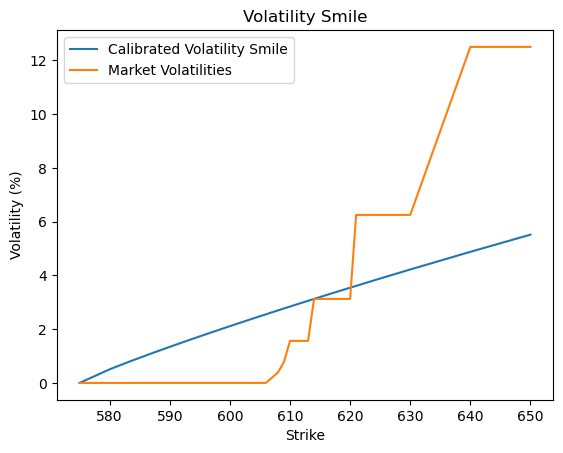

In [30]:
import matplotlib.pyplot as plt
from pysabr import hagan_2002_lognormal_sabr as sabr

# Generate calibrated volatilities using the SABR model
calibrated_vols = [
    sabr.lognormal_vol(strike, f, t, alpha, beta, rho, volvol) * 100  # Convert to percentage
    for strike in strikes
]

# Plot the calibrated volatility smile
plt.plot(
    strikes,  # Strike prices
    calibrated_vols,  # SABR model calibrated volatilities
    label="Calibrated Volatility Smile"
)

# Overlay the market volatilities for comparison
plt.plot(
    strikes,  # Strike prices
    vols,  # Market implied volatilities
    label="Market Volatilities"
)

# Add labels and title
plt.xlabel("Strike")
plt.ylabel("Volatility (%)")
plt.title("Volatility Smile")
plt.legend()

# Show the plot
plt.show()
